In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from random import randint
from torch.nn import Identity
from torchvision import datasets, models, transforms
import torchvision

import pandas as pd

import numpy as np

import random
import os

%matplotlib inline
import matplotlib.pyplot as plt
import json
import cv2
import logging

from torch.utils.data import Dataset, DataLoader

from torch.optim.lr_scheduler import ReduceLROnPlateau
import imgaug.augmenters as iaa

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, RocCurveDisplay, accuracy_score

path_local_sms = '../../../DATA/SolovyevDA/datasets/self_made_v2/' # root dir
csv_name = 'self_made_set_v2_full.csv'

path_local_celeba = '../../../DATA/spoof_sets/CelebA_Spoof/'#'../input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/'

In [ ]:
def filter_df(df, lower_n = False, binary = False, n = 6, onlydisplay=False):
    if onlydisplay:
        df = df[[x in [0,7,8,9] for x in list(df['Class'])]].reset_index()
    
    if lower_n:
        df = df[df['Class'] < n].reset_index()
        
    if binary:
        df['Class'] = df['Class'].apply(lambda x: get_class(x))
    
    return df

def get_class(x):
    if x == 0:
        return 0
    else:
        return 1


def softmax(v):
    return np.exp(v) / sum(np.exp(v))

def calc_tpr_fpr(y_true, y_pred):
    m = confusion_matrix(y_true, y_pred)
    
    tp = m[1,1]
    fp = m[0, 1]
    tn = m[0, 0]
    fn = m[1, 0]
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return tpr, fpr

In [ ]:
path_to_sms_preds = 'pad_0.3/preds_sms'#'../../../DATA/SolovyevDA/store/32/preds_sms'
path_to_celeba_preds = 'pad_0.3/preds_celeba'#'../../../DATA/SolovyevDA/store/32/preds_celeba'

cnt = len(os.listdir(path_to_sms_preds))
print(len(os.listdir(path_to_sms_preds)))
print(len(os.listdir(path_to_celeba_preds)))

35
35


In [ ]:
path_to_sms_preds += '/mobnet_v2_'
path_to_celeba_preds += '/mobnet_v2_'

In [ ]:
df_celeba = pd.read_csv('test.csv')
df_celeba = filter_df(df_celeba, True, True, 6, False)
print(len(df_celeba))

45411


In [ ]:
df_sms = pd.read_csv(path_local_sms + csv_name)
df_sms = df_sms[df_sms['cam_type'] != 'ik']
print(len(df_sms))

25138


In [ ]:
df_sms.tail()

,path,class,illumination,descr,sc_id,range,cam_type
35818,live/good_env/near/10/800000_1_0.998687.jpg,1,light,live_face,110,near,optic
35819,live/good_env/near/10/800000_2_0.993772.jpg,1,light,live_face,110,near,optic
35820,live/good_env/near/10/899999_0_0.994541.jpg,1,light,live_face,110,near,optic
35821,live/good_env/near/10/899999_1_0.996458.jpg,1,light,live_face,110,near,optic
35822,live/good_env/near/10/899999_2_0.997262.jpg,1,light,live_face,110,near,optic


In [ ]:
y_true = list(df_sms['class'])
y_true = [1 if x == 0 else 0 for x in y_true] # switch classes if model's output[0] == live class

In [ ]:
acc_no_tr = []

for i in range(0, cnt):
    path = path_to_celeba_preds + str(i) + '.txt'

    with open(path, 'r') as f:
        l = f.readlines()
        preds = []
        for e in l:
            preds.append([float(x) for x in e.replace('\n', '').split(' ')[:-1]])
  
    
    preds = [softmax(x) for x in preds]      
        
    preds_ = np.argmax(preds, axis=1)
    preds_ = [0 if x == 0 else 1 for x in preds_]
    y = list(df_celeba['Class'])
 
    acc_no_tr.append(f1_score(y, preds_))

In [ ]:
acc_tr_1 = []

for i in range(0, cnt):
    path = path_to_celeba_preds + str(i) + '.txt'

    with open(path, 'r') as f:
        l = f.readlines()
        preds = []
        for e in l:
            preds.append([float(x) for x in e.replace('\n', '').split(' ')[:-1]])
    
    preds = [softmax(x) for x in preds]      
        
    preds_ = np.argmax(preds, axis=1)
    preds_ = [0 if x == 0 else 1 for x in preds_]
    y = list(df_celeba['Class'])
    maxs = np.max(preds, axis=1)
    ans = []
    
    for a, b in zip(preds_, maxs):
        
        if b > 0.75 and a == 0:
            ans.append(0)
        else:
            ans.append(1)
            
    acc_tr_1.append(f1_score(y, ans))

In [ ]:
acc_tr_2 = []

for i in range(0, cnt):
    path = path_to_celeba_preds + str(i) + '.txt'

    with open(path, 'r') as f:
        l = f.readlines()
        preds = []
        for e in l:
            preds.append([float(x) for x in e.replace('\n', '').split(' ')[:-1]])
    
    preds = [softmax(x) for x in preds]      
        
    preds_ = np.argmax(preds, axis=1)
    preds_ = [0 if x == 0 else 1 for x in preds_]
    y = list(df_celeba['Class'])
    maxs = np.max(preds, axis=1)
    ans = []
    
    for a, b in zip(preds_, maxs):
        
        if b > 0.9 and a == 0:
            ans.append(0)
        else:
            ans.append(1)
            
    acc_tr_2.append(f1_score(y, ans))

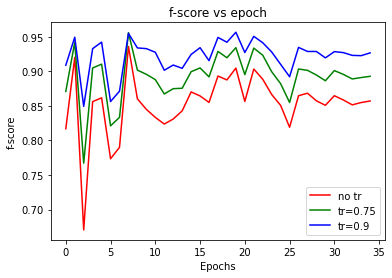

In [ ]:
plt.plot(acc_no_tr, 'r', label='no tr')
plt.plot(acc_tr_1, 'g', label='tr=0.75')
plt.plot(acc_tr_2, 'b', label='tr=0.9')
plt.title('f-score vs epoch')
plt.xlabel('Epochs')
plt.ylabel('f-score')
plt.legend()
plt.show()

In [ ]:
tr_list = range(5, 100, 5)

In [ ]:
tprs = []
fprs = []
d = {}
for i in range(cnt):
    d[i] = []
    path = path_to_celeba_preds + str(i) + '.txt'

    preds = []

    with open(path, 'r') as f:
        l = f.readlines()
        for e in l:
            preds.append([float(x) for x in e.replace('\n', '').split(' ')[:-1]])
    
    activations = [softmax(x) for x in preds]

    
    for tr in tr_list:
        tr = tr / 100.

        y_pred = [0 if x[0] > tr else 1 for x in activations]

        tpr, fpr = calc_tpr_fpr(y, y_pred)
        d[i].append((tr, tpr, fpr))
        

In [ ]:
d

{0: [(0.05, 0.4915254237288136, 0.0019575365155850024),
  (0.1, 0.5409996861268048, 0.003915073031170005),
  (0.15, 0.5700721908349027, 0.005019324398935903),
  (0.2, 0.5918863779033271, 0.006525121718616674),
  (0.25, 0.6107580037664784, 0.007930532550318727),
  (0.3, 0.6293157564344005, 0.009687296089946293),
  (0.35, 0.6477950408035154, 0.011042513677658987),
  (0.4, 0.6649011299435028, 0.01294985694925463),
  (0.45, 0.6831450094161958, 0.01505797319680771),
  (0.5, 0.699741054613936, 0.01706570295638207),
  (0.55, 0.7183380414312618, 0.019675751643828742),
  (0.6, 0.7343455743879472, 0.02283792601515836),
  (0.65, 0.7521971123666039, 0.025297394970636954),
  (0.7, 0.7713433772755807, 0.02901169502584952),
  (0.75, 0.7915097300690521, 0.03327812076494504),
  (0.8, 0.8131669805398619, 0.0392009235556894),
  (0.85, 0.8395323289391086, 0.04637855744616774),
  (0.9, 0.8706842435655995, 0.05782261707574161),
  (0.95, 0.9159604519774012, 0.08116247553079356)],
 1: [(0.05, 0.66662743251726

In [ ]:
acc_no_tr = []

for i in range(0, cnt):
    path = path_to_sms_preds + str(i) + '.txt'

    with open(path, 'r') as f:
        l = f.readlines()
        preds = []
        for e in l:
            preds.append([float(x) for x in e.replace('\n', '').split(' ')[:-1]])
  
    
    preds = [softmax(x) for x in preds]      
        
    preds_ = np.argmax(preds, axis=1)
    preds_ = [0 if x == 0 else 1 for x in preds_]
 
    acc_no_tr.append(f1_score(y_true, preds_, average='macro'))

In [ ]:
acc_tr_1 = []

for i in range(0, cnt):
    path = path_to_sms_preds + str(i) + '.txt'

    with open(path, 'r') as f:
        l = f.readlines()
        preds = []
        for e in l:
            preds.append([float(x) for x in e.replace('\n', '').split(' ')[:-1]])
    
    preds = [softmax(x) for x in preds]      
        
    preds_ = np.argmax(preds, axis=1)
    preds_ = [0 if x == 0 else 1 for x in preds_]
    
    maxs = np.max(preds, axis=1)
    ans = []
    
    for a, b in zip(preds_, maxs):
        
        if b > 0.75 and a == 0:
            ans.append(0)
        else:
            ans.append(1)
            
    acc_tr_1.append(f1_score(y_true, ans, average='macro'))

In [ ]:
acc_tr_2 = []

for i in range(0, cnt):
    path = path_to_sms_preds + str(i) + '.txt'

    with open(path, 'r') as f:
        l = f.readlines()
        preds = []
        for e in l:
            preds.append([float(x) for x in e.replace('\n', '').split(' ')[:-1]])
    
    preds = [softmax(x) for x in preds]      
        
    preds_ = np.argmax(preds, axis=1)
    preds_ = [0 if x == 0 else 1 for x in preds_]
    
    maxs = np.max(preds, axis=1)
    ans = []
    
    for a, b in zip(preds_, maxs):
        
        if b > 0.9 and a == 0:
            ans.append(0)
        else:
            ans.append(1)
            
    acc_tr_2.append(f1_score(y_true, ans, average='macro'))

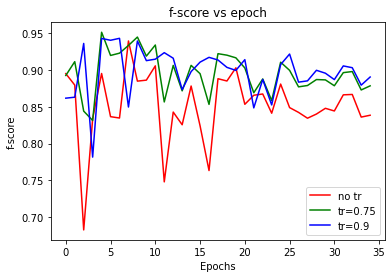

In [ ]:
plt.plot(acc_no_tr, 'r', label='no tr')
plt.plot(acc_tr_1, 'g', label='tr=0.75')
plt.plot(acc_tr_2, 'b', label='tr=0.9')
plt.title('f-score vs epoch')
plt.xlabel('Epochs')
plt.ylabel('f-score')
plt.legend()
plt.show()